# Estimating Drivers of Immigration Flows to the US

_Are people moving to the United States because they are seeking economic opportunity or are they moving because they are fleeing violence in their home country?_

Our analysis seeks to answer the above question using a linear regression model that includes GDP per capita as a proxy for economic opportunity and homicides as a proxy for violence, while controlling for population size and distance between origin country and the United States.


## Summary Results

* Income and homicide counts are **strong predictors** of immigration flows to the US 
* All else equal, one-standard deviation increase in the **income gap** between the US and other countries will **decrease immigration to the US by 7%**
* All else equal, one-standard deviation increase in the **homicide gap** between the US and other countries will **increase immigration to the the US by 41%**

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
np.random.seed(123)

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Files to Load 
Working_Data_Long = "Working_Data_Long.csv"
Regions = "Regions.csv"

# Read Data
df_full = pd.read_csv(Working_Data_Long)
df_regions = pd.read_csv(Regions)

# Merge Regions
df0 = pd.merge(df_regions, df_full, how='inner', on=('Country','ISO'))

# Take difference between US and other countries
df0['DIncome'] = df0['Ln_Income'] - df0['Ln_USIncome']
df0['DHomicides'] = df0['Ln_Homicides'] - df0['Ln_USHomicides']
df0['DPop'] = df0['Ln_Pop'] - df0['Ln_USPop']

# Keep selected variables for model#
df0 = df0[['Country','Year','Ln_Inflows','DIncome','DHomicides','DPop','Ln_Distance']]

## Data 

1. **Country** - 182 unique countries
2. **Year** - annual data from 1999 to 2017
3. **Inflows** - number of individuals that were granted Lawful Permanent Residence status in the US (LPRs). We use it as a proxy for immigration inflows to the US. _Source: Migration Policy Insitute._
4. **Income** - GDP per capita in USD. _Source: IMF World Economic Outlook Database._
5. **Homicides** - counts of unlawful homicides purposefully inflicted as a result of domestic disputes, intentional violence, violent conflicts over land resources, intergang violence over turf or control, predatory violence and killing by armed groups. Excludes killings in armed conflict. _Source: United Nations Office on Drugs and Crime._
6. **Population** - population counts in millions. _Source: IMF World Econonic Outlook Database._
7. **Distance** - the distance in kilometers between capitals. _Source: Le Centre d’études prospectives et d’informations internationales (CEPII)._

Our panel dataset consists of 3,477 rows and 7 columns, however, it is not a balanced panel. Data are not available for all years and countries. For example, some countries do not report statistics on homicides, which is one of our variables of interest. 

When we look at the distribution of missing values in our dataset, homicides contributes to 32.15% of all missing values. Given that this represents a substantial loss in sample size, we will test for sample selection bias. This will allow us to validate whether the countries that are not included in our sample are biasing our results.

In [3]:
# Percentage of missing values for each column
df0.isnull().mean().round(4) * 100

Country         0.00
Year            0.00
Ln_Inflows      1.67
DIncome         1.09
DHomicides     32.15
DPop            1.06
Ln_Distance     2.73
dtype: float64

## OLS Estimations

Ordinary least squares regression (OLS) is a statistical method used to determine the linear relationship between two or more variables. OLS minimizes the sum of the squares of the differences between the observed dependent variable (values of the variable being predicted) and those predicted by the linear function.

There is a set of assumptions that need to be met in order for the OLS estimators to be unbiased. Violation of these assumptions will risk biasing the results and cause problems in estimating the regression coefficients.

**Gauss-Markov Assumptions:**
1. Linearity – the relationships between the predictors and the outcome variable are linear
2. Normality – the errors are normally distributed – technically normality is necessary only for hypothesis tests to be valid, estimation of the coefficients only requires that the errors be identically and independently distributed
3. Homogeneity of variance (homoscedasticity) – the error variance is constant across all observations
4. Independence – the errors associated with one observation are not correlated with the errors of any other observation
5. Errors in variables – predictor variables are measured without error
6. Model specification – the model is properly specified (including all relevant variables, and excluding irrelevant variables)

_Source: Regression with Stata._

### Model 1: Income

In our first model, we estimate the relationship between immigration flows and GDP per capita, which we use as a proxy for economic opportunity. 

Since the relationship may not be linear in parameters, we chose a Log-Log model. Log transformation will ensure the desired linearity in parameters. Additionally, coefficients can be used to determine the impact of income on immigration flows. 

__Ln_Inflows = Constant + DIncome + DPop + Ln_Distance + u__

* **Ln_Inflows** is our dependent variable, calculated as the natural log of immigration inflows to the US.
* **DIncome** is our explanatory variable, calculated as the difference between the natural log of GDP per capita in origin country and that of the US. 
* **DPop** is our control for population size, calculated as the difference in natural log of population origin country and that of the US. 
* **Ln_Distance** is our control of distance between origin country to the US.

We expect the coefficient on income to be negative. Higher income in origin country will lower immigration flows to the US.


__Hypothesis Test:__

_H0: The difference in income per capita in origin country does not affect immigration flows to the US_

_HA: The difference in income per capita in origin country affects immigration flows to the US_

The results of our model show that the difference in income per capita is negatively associated with immigration flows after conditioning on other comfounding variables. The coefficient is negative and statistically significant, implying that countries with higher income have lower flows of immgiration to the US. Therefore, we reject the _H0._

In [4]:
# Keep selected variables for model
df1 = df0

# Replace Inf, -Inf with NaN, then delete NaN
df1['Ln_Inflows'] = df1['Ln_Inflows'][df1['Ln_Inflows'].replace([np.inf, -np.inf], np.nan).notnull()]

# Must drop NAs, otherwise the regression will not run (SVD not converging)
df1 = df1.dropna()

# OLS Model for Income
y = df1['Ln_Inflows']
xs = sm.add_constant(df1[['DIncome','DPop','Ln_Distance']])

# Fit and summarize OLS model with robust standard errors
mod1 = sm.OLS(y, xs)
res1 = mod1.fit(cov_type='HC3')
print(res1.summary())

# Write regression results to csv file
f = open('Table_1.csv','w')
f.write(res1.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:             Ln_Inflows   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     631.5
Date:                Sat, 27 Jul 2019   Prob (F-statistic):          1.14e-298
Time:                        10:52:42   Log-Likelihood:                -3963.1
No. Observations:                2281   AIC:                             7934.
Df Residuals:                    2277   BIC:                             7957.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          19.8411      0.858     23.122      

1235

In [5]:
# Summary Statistics
stats1 = df1[['Ln_Inflows','DIncome','DPop','Ln_Distance']]
round(stats1.describe(),2)

,Ln_Inflows,DIncome,DPop,Ln_Distance
count,2281.00,2281.00,2281.00,2281.00
mean,7.21,-2.05,-3.77,8.88
std,2.00,1.47,2.04,0.59
min,1.10,-5.51,-8.74,6.60
25%,6.12,-3.14,-4.76,8.68
50%,7.23,-2.09,-3.67,8.96
75%,8.59,-0.75,-2.35,9.34
max,12.30,0.88,1.51,9.70


###### Measuring Economic Significance - Model 1

Using the regression results and the summary statistics, we can measure the economic impact of higher income on immigration flows to the US. 

Parameters: Coefficient for income is -0.1701 and the Standard deviation for income is 1.47 

beta x sigma = -0.1701 x 1.47 = -0.25 = Change in Y

Y = ln(Inflows)

Change in Y = -0.25

Y1 - 0.25 = Y2

Y1 - Y2 = 0.25 

ln(Inflows_1) - ln(Inflows_2) = 0.25

ln(Inflows_1 / Inflows_2) = 0.25 

Inflows_1 / Inflows_2 = e^0.25 

e^0.25 = 1.28

Inflows_1 * 1/1.28 = Inflows_2 

Inflows_1 * 0.78 = Inflows_2 

Change in Y = 1 - 0.78 = 0.22 or 22% 

Since the effect is negative (negative sign on coefficient), the change in Y will be -22%.

**Thus, all else equal, a one standard deviation increase in the income gap will decrease immigration flows to the US by 22%.**


### Model 2: Homicides

In our second model, we estimate the relationship between immigration flows and homicides, which we determine to be a good proxy for violence in a country.  

Since the relationship may not be linear in parameters, we chose a Log-Log model. Log transformation will ensure the desired linearity in parameters. Additionally, coefficients can be used to determine the impact of homicides on immigration flows. 


__Ln_Inflows = Constant + DHomicides + DPop + Ln_Distance + u__

* **Ln_Inflows** is our dependent variable, calculated as the natural log of immigration inflows to the US.
* **DHomicides** is our explanatory variable, calculated as the difference between the natural log of homicides in origin country and that of the US. 
* **DPop** is our control for population size, calculated as the difference in natural log of population origin country and that of the US. 
* **Ln_Distance** is our control of distance between origin country to the US.

We expect the coefficient on homicidtes to be positive. Higher homicides in origin country will increase immigration flows to the US.


__Hypothesis Test:__

_H0: The difference in homicides in origin country does not affect immigration flows to the US_

_HA: The difference in homicides in origin country affects immigration flows to the US_

The results of our model show that homicides are postively associated with migration inflows. The coefficient is positive and highly statistically significant, suggseting that countries that have higher homicides have higher immigration flows to the US. Therefore, we reject the _H0._

In [6]:
# Keep selected variables for model
df2 = df0

# Replace Inf, -Inf with NaN, then delete NaN
df2['Ln_Inflows'] = df2['Ln_Inflows'][df2['Ln_Inflows'].replace([np.inf, -np.inf], np.nan).notnull()]
df2['DHomicides'] = df2['DHomicides'][df2['DHomicides'].replace([np.inf, -np.inf], np.nan).notnull()]

# Must drop NAs, otherwise the regression will not run (SVD not converging)
df2 = df2.dropna()

# OLS Model for Homicides
y = df2['Ln_Inflows']
xs = sm.add_constant(df2[['DHomicides','DPop','Ln_Distance']])

# Fit and summarize OLS model with robust standard errors
mod2 = sm.OLS(y, xs)
res2 = mod2.fit(cov_type='HC3')
print(res2.summary())

# Write regression results to csv file
f = open('Table_2.csv','w')
f.write(res1.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:             Ln_Inflows   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     705.6
Date:                Sat, 27 Jul 2019   Prob (F-statistic):          4.94e-324
Time:                        10:52:42   Log-Likelihood:                -3923.7
No. Observations:                2274   AIC:                             7855.
Df Residuals:                    2270   BIC:                             7878.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.4984      0.955     18.319      

1235

In [7]:
# Summary Statistics
stats2 = df2[['Ln_Inflows','DHomicides','DPop','Ln_Distance']]
round(stats2.describe(),2)

,Ln_Inflows,DHomicides,DPop,Ln_Distance
count,2274.00,2274.00,2274.00,2274.00
mean,7.22,-4.12,-3.77,8.88
std,1.99,2.25,2.04,0.59
min,1.10,-9.85,-8.74,6.60
25%,6.13,-5.61,-4.74,8.68
50%,7.23,-4.09,-3.66,8.96
75%,8.59,-2.84,-2.35,9.34
max,12.30,1.42,1.51,9.70


### Measuring Economic Signicance - Model 2

Using the regression results and the summary statistics, we can measure the economic impact of higher homicides on immigration flows to the US. 

Parameters: Coefficient for income is 0.2743 and the Standard deviation for income is 2.25 

beta x sigma = 0.2743 x 2.25 = 0.617 = Change in Y

Y = ln(Inflows)

Change in Y = 0.617

Y1 - 0.617 = Y2

Y1 - Y2 = 0.617

ln(Inflows_1) - ln(Inflows_2) = 0.617

ln(Inflows_1 / Inflows_2) = 0.617 

Inflows_1 / Inflows_2 = e^0.617 

e^0.617 = 1.85

Inflows_1 x 1/1.85 = Inflows_2 

Inflows_1 x 0.54 = Inflows_2 

Change in Y = 1 - 0.54 = 0.46 or 46% 

**Holding all esle constant, a one standard deviation increase in homicide gap will increase immigration flows to the US by 46%.**


### Model 3: Income and Homicides

In our third model, we estimate whether people are moving to the United States because they are seeking economic opportunity and/or they are fleeing violence in their home country.   

Since the relationship may not be linear in parameters, we chose a Log-Log model. Log transformation will ensure the desired linearity in parameters. Additionally, coefficients can be used to estimate the impact of our _Xs_ on _Y_, e.g. the estimated percent change in _Y_ for a percent change in _X_. We show this when we measure the economic impact below.


__Ln_Inflows = Constant + DIncome + DHomicides + DPop + Ln_Distance + u__

* **Ln_Inflows** is our dependent variable, calculated as the natural log of immigration inflows to the US.
* **DIncome** is our explanatory variable, calculated as the difference between the natural log of GDP per capita in origin country and that of the US. 
* **DHomicides** is our explanatory variable, calculated as the difference between the natural log of homicides in origin country and that of the US. 
* **DPop** is our control for population size, calculated as the difference in natural log of population origin country and that of the US. 
* **Ln_Distance** is our control of distance between origin country to the US.

__Hypothesis Test:__

_H0: The difference in per capita income and homicides in origin country does not affect immigration flows to the US_

_HA: The difference in per capita income and homicides in origin country affects immigration flows to the US_

The results of our model show that our variables of interest, income and homicides, are strongly correlated with immigration flows to the US. 

* The coefficient on income is negative and highly statistically significant, suggesting that countries that have higher income, have lower immigration flows to the US.
* The coefficient on homicides is positive and highly statistically significant, suggseting that countries that have higher homicides, have higher immigration flows to the US. 
* Therefore, we reject the _H0._

We can't definitively conclude that if a country were to increase its income, it would lower immigration to the US. However, our results point towards that finding.

Importantly, this is not a causal inference. Our research design does not allow us to make that conclusion. 

In [8]:
# Keep selected variables for model
df3 = df0

# Replace Inf, -Inf with NaN, then delete NaN
df3['Ln_Inflows'] = df3['Ln_Inflows'][df3['Ln_Inflows'].replace([np.inf, -np.inf], np.nan).notnull()]
df3['DIncome'] = df3['DIncome'][df3['DIncome'].replace([np.inf, -np.inf], np.nan).notnull()]
df3['DHomicides'] = df3['DHomicides'][df3['DHomicides'].replace([np.inf, -np.inf], np.nan).notnull()]

# Must drop NAs, otherwise the regression will not run (SVD not converging)
df3 = df3.dropna()

# OLS Model for Homicides
y = df3['Ln_Inflows']
xs = sm.add_constant(df3[['DIncome','DHomicides','DPop','Ln_Distance']])

# Fit and summarize OLS model with robust standard errors
mod3 = sm.OLS(y, xs)
res3 = mod3.fit(cov_type='HC3')
print(res3.summary())

# Write regression results to csv file
f = open('Table_3.csv','w')
f.write(res1.summary().as_csv())

                            OLS Regression Results                            
Dep. Variable:             Ln_Inflows   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     554.1
Date:                Sat, 27 Jul 2019   Prob (F-statistic):               0.00
Time:                        10:52:42   Log-Likelihood:                -3921.0
No. Observations:                2274   AIC:                             7852.
Df Residuals:                    2269   BIC:                             7881.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.9102      0.923     19.394      

1235

In [9]:
# Summary Statistics
stats3 = df3[['Ln_Inflows','DIncome','DHomicides','DPop','Ln_Distance']]
round(stats3.describe(),2)

,Ln_Inflows,DIncome,DHomicides,DPop,Ln_Distance
count,2274.00,2274.00,2274.00,2274.00,2274.00
mean,7.22,-2.05,-4.12,-3.77,8.88
std,1.99,1.47,2.25,2.04,0.59
min,1.10,-5.51,-9.85,-8.74,6.60
25%,6.13,-3.15,-5.61,-4.74,8.68
50%,7.23,-2.09,-4.09,-3.66,8.96
75%,8.59,-0.76,-2.84,-2.35,9.34
max,12.30,0.88,1.42,1.51,9.70


### Measuring Economic Significance - Model 3

** Income **

Using the regression results and the summary statistics, we can measure the economic impact of higher income on immigration flows to the US. 

Parameters: Coefficient for income is -0.0566 and the Standard deviation for income is 1.47

beta x sigma = -0.0566 x 1.47 = -0.083 = Change in Y

Y = ln(Inflows)

Change in Y = -0.083

Y1 - 0.083 = Y2

Y1 - Y2 = 0.083

ln(Inflows_1) - ln(Inflows_2) = 0.083

ln(Inflows_1 / Inflows_2) = 0.083 

Inflows_1 / Inflows_2 = e^0.083 

e^0.083 = 1.07

Inflows_1 x 1/1.07 = Inflows_2 

Inflows_1 x 0.93 = Inflows_2 

Change in Y = 1 - 0.93 = 0.07 or 7% 

Since the effect is negative (negative sign on coefficient), the change in Y will be -7%.

**All else equal, a one-standard deviation increase in income gap will decrease immigration flows to the US by 7%.**

******
** Homicides **

Using the regression results and the summary statistics, we can measure the economic impact of higher homicides on immigration flows to the US. 

Parameters: Coefficient for income is 0.2355 and the Standard deviation for income is 2.25 

beta x sigma = 0.2355 x 2.25 = 0.529 = Change in Y

Y = ln(Inflows)

Change in Y = 0.529

Y1 - 0.529 = Y2

Y1 - Y2 = 0.529

ln(Inflows_1) - ln(Inflows_2) = 0.529

ln(Inflows_1 / Inflows_2) = 0.529 

Inflows_1 / Inflows_2 = e^0.529 

e^0.529 = 1.70

Inflows_1 x 1/1.70 = Inflows_2 

Inflows_1 x 0.59 = Inflows_2 

Change in Y = 1 - 0.59 = 0.41 or 41% 

**All else equal, a one standard deviation increase in homicide gap will increase immigration flows to the US by 41%.**

## Model Diagnostics

We are testing the first two assumptions for OLS with the help of a Residual Plot and a Q-Q Plot. 
1. Linearity – the relationships between the predictors and the outcome variable should be linear
2. Normality – the errors should be normally distributed – technically normality is necessary only for hypothesis tests to be valid, estimation of the coefficients only requires that the errors be identically and independently distributed

### Q-Q Plot

The points fall along a line in the middle of the graph, but curve off in the extremities, suggesting a heavy-tailed distribution. Normal Q-Q plots that exhibit this behavior usually mean that the data have more extreme values than would be expected if they truly came from a Normal distribution.


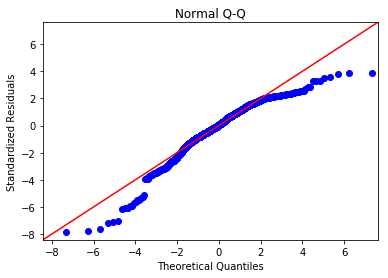

In [10]:
# Q-Q Plot
mod_fit = sm.OLS(y, xs).fit(cov_type='HC3')
res = mod_fit.resid

fig = sm.qqplot(res, stats.t, fit=True, line='45')
fig.axes[0].set_title('Normal Q-Q')
fig.axes[0].set_xlabel('Theoretical Quantiles')
fig.axes[0].set_ylabel('Standardized Residuals')

# Save Figure
plt.savefig('QQ_Plot.png')

plt.show()

### Residual Plot

The Residual plot shows that the residuals are fairly randomly dispersed around the horizontal axis, with the exception of some outliers in the bottom right. This random pattern indicates that a linear model provides a decent fit to the data.

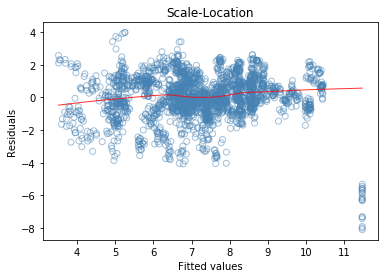

In [11]:
# Model values
model_fitted_y = res3.fittedvalues

# Model residuals
model_residuals = res3.resid

fig_res = plt.figure()
plt.scatter(model_fitted_y, model_residuals, facecolors='none', edgecolors='steelblue', alpha=0.5);
sns.regplot(model_fitted_y, model_residuals,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
fig_res.axes[0].set_title('Scale-Location')
fig_res.axes[0].set_xlabel('Fitted values')
fig_res.axes[0].set_ylabel('Residuals');

# Save Figure
plt.savefig('Residual_Plot.png')


# Testing for Sample Selection Bias

We have considered the presence of sample selection bias in our data. For example, when adding homicides to our Final Model (Model 3), our sample size shrinks by 31%, e.g. it goes from 3,307 observations to 2,274. 

To determine whether sample selection bias is present, we test the following models with income:

1. Big set of variables, small set of countries (see **Model 4**)
2. Small set of variables, big set of countries (see **Model 1**)
3. Intersection of the two (see **Model 3**)


__Hypothesis Test:__

_H0: There is no selection bias_

_HA: There is selection bias_

In other words, if the coefficient on income is the same in (1) and in (3), then there's no selection bias.

* The coefficient in (1) is -0.1681 and the coefficient in (3) is -0.1701. They are both approximately the same. Thus, we fail to reject _H0_ of no selection bias. 

**We do not find evidence of sample selection bias in our dataset**. 

And the reason why we want to check for sample selection bias is because we want to know if countries that do not produce homicide data may be systematically different from those that do.

### Model 4: Estimating Income on Small Sample

In [12]:
# OLS Model for Income using small sample (2274 obs)
y = df3['Ln_Inflows']
xs = sm.add_constant(df3[['DIncome','DPop','Ln_Distance']])

# Fit and summarize OLS model
mod4 = sm.OLS(y, xs)
res4 = mod4.fit(cov_type='HC3')
print(res4.summary())

                            OLS Regression Results                            
Dep. Variable:             Ln_Inflows   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     619.6
Date:                Sat, 27 Jul 2019   Prob (F-statistic):          3.50e-294
Time:                        10:52:44   Log-Likelihood:                -3952.3
No. Observations:                2274   AIC:                             7913.
Df Residuals:                    2270   BIC:                             7935.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          19.8315      0.859     23.084      

## Summary Results

* Income and homicide counts are **strong predictors** of immigration flows to the US 
* All else equal, one-standard deviation increase in the **income gap** between the US and other countries will **decrease immigration to the US by 7%**
* All else equal, one-standard deviation increase in the **homicide gap** between the US and other countries will **increase immigration to the the US by 41%**
* We tested for sample selection bias and did not find any.

## Next Steps

* Use total immigration flows instead of the smaller population of immigrants who have been granted LPRs.
* Do the same analysis for LPRs, asylum seekers, and individuals with irregular status seperately to estimate what driver is the strongest for each group
* Look at other drivers of migration:
    * Environmental catastrophes in origin country
    * Family relationships in the US
    * Urbanization